2025-11-25. Demo of restructured mass spectrum simulation project

This notebook tests my scripts for a small subset of the molecules in my real dataset. 
In the future, we can use this for a workflow demo. 

## 0. Create a toy dataset as a subset from real dataset

In [23]:
import pandas as pd

# Load full dataset
df = pd.read_csv('../data/raw/Franklin/goamazon.csv')

# Pick 4 molecules by index:
toy_indices = [0, 1, 2, 3]  # first 4 rows for simplicity
toy_df = df.iloc[toy_indices].copy()

# Duplicate 2 of them, say first and third
duplicates = toy_df.iloc[[0, 2]].copy()
toy_df = pd.concat([toy_df, duplicates], ignore_index=True)

# Save toy dataset
toy_df.to_csv('../data/raw/toy_data/toy_dataset.csv', index=False)

## 1. Remove duplicates from dataset and write smiles in canonical form. Output: A list of SMILES to use as input for derivitization. 

In [24]:
! . ~/.bashrc
!echo $SCRIPTS_NEIMS/processing

/scratch/project_2006752/hsandstr/Project/atmospheric-ms-benchmark/src/processing


In [46]:
%run /scratch/project_2006752/hsandstr/Project/atmospheric-ms-benchmark/src/processing/remove_duplicate_SMILES_entries.py -i ../data/raw/Franklin/goamazon.csv -o ../data/processed/toy_data/toy_dataset_unique.csv  --log_file ../data/processed/toy_data/toy_dataset_duplicates.csv


Saved 61 unique molecules to ../data/processed/toy_data/toy_dataset_unique.csv
Saved duplicate mapping to ../data/processed/toy_data/toy_dataset_duplicates.csv


## 2.1 Derivatize molecules. Output: A list of derivatized SMILES for input to MS simulations

<Figure size 2000x1500 with 0 Axes>

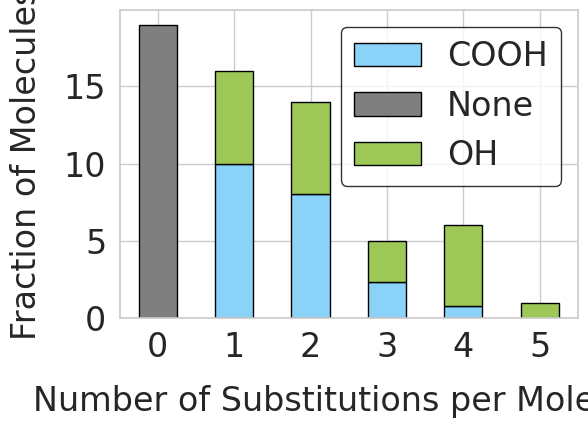


Percentage of equality: 95.08%

Mismatched rows:
Index 7: s1 = 1, s2 = 0.0, SMILES s1 = C[Si](C)(C)OC1=CC=CC=C1C(=O)OC1CC(C)CC(C)(C)C1, SMILES s2 = CC1CC(OC(=O)C2=CC=CC=C2O)CC(C)(C)C1
Index 26: s1 = 1, s2 = 0.0, SMILES s1 = C[Si](C)(C)OC1=CC(OC)=CC(OC)=C1C(C)=O, SMILES s2 = COC1=CC(OC)=C(C(C)=O)C(O)=C1
Index 58: s1 = 2, s2 = 0.0, SMILES s1 = C[Si](C)(C)OC(=O)C1=CC=CC=C1C(=O)O[Si](C)(C)C, SMILES s2 = O=C(O)C1=CC=CC=C1C(=O)O


In [48]:
%run /scratch/project_2006752/hsandstr/Project/atmospheric-ms-benchmark/src/processing/make_TMS_derivative_251125_v1.py --compare_ref \
    -i ../data/processed/toy_data/toy_dataset_unique.csv \
    -o ../data/processed/toy_data_tms/toy_dataset_TMS.csv


## 3. Make molecule folders and run sdf from smiles

## 4.1 Run the initial QCxMS ground state optimization and MD

## 4.2 Run QCxMS fragmentation script for each molecule

## 4.3 Run QCxMS postprocessing: check that number of successful frag. runs was more than 90 %,
## and generate a raw spectra (unfiltered, with floats for m/z numbers)

## 5.1 Run NEIMS for each molecule using the optimized SDF

## 5.2 Run CFM-ID for compounds it is valid for 

## 6. Compare NEIMS and QCxMS spectra to eachother and to the reference spectra (choices, binning all peaks to closest integer, then removing peaks with X % of base peak intensity)

## 6.1 Test only using 20 most strong signals 

## 7. Plot results